# Курс «Введение в нейронные сети»

## Урок 7. Детектирование объектов

### Домашняя работа к уроку 7

#### Задание 1

Сделайте краткий обзор какой-нибудь научной работы посвященной тому или иному алгоритму для object detection, который не рассматривался на уроке. Проведите анализ: Чем отличается выбранная вами на рассмотрение архитектура нейронной сети от других архитектур? В чем плюсы и минусы данной архитектуры? Какие могут возникнуть трудности при применении данной архитектуры на практике?

Рассматриваем статью "Review: RetinaNet — Focal Loss (Object Detection)"
https://towardsdatascience.com/review-retinanet-focal-loss-object-detection-38fba6afabe4

**Обзор: RetinaNet - потеря фокуса (обнаружение объектов)**

В обзоре рассмотрена проблема дисбаланса классов для однопроходных нейронных сетей для определения объектов на изображении. Это одна из причин по которой однопроходные нейронные стети уступают двухпроходным. В качестве решения данной проблемы предложена потеря фокуса, что позволяет сосредоточится на более значимых образцах. Для исследования выбрана сеть RetinaNet.

**Проблема дисбаланса классов однопроходного детектора**

Для двухкаскадных детекторов на первом этапе отфильтровывается большинство фоновых выборок за счет отсева возможных местоположений объекта, на втором этапе происходит классификация каждого объекта-кандидата, таким образом осуществляется баланс между классами переднего и заднего плана.

Для однокаскадных детекторов на изображении осуществляется гораздо больший отбор местоположений объектов, которые плотно заполняют все возможные пространственные положения, масштабы и соотношения сторон возле детектируемых объектов, в результате чего образуется очень много выбранных фоновых объектов.

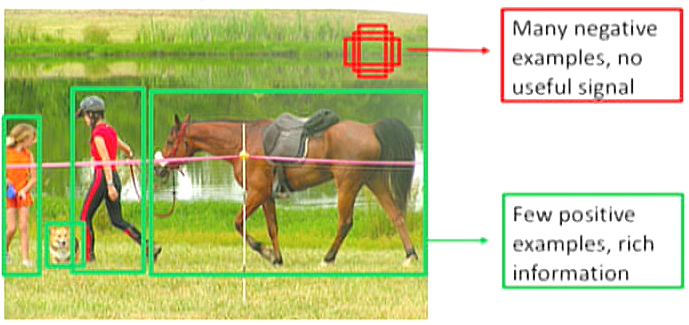
На изображении видно как нейросеть выделила множество объектов заднего плана, и несколько объектов переднего плана.

 **Потеря фокуса**

Далее рассматриваются различные варианты отбора объектов детектирования:
    - Потеря перекрестной энтропии (CE)
    - Альфа-сбалансированные потери (СЕ)
    - Потери фокуса (FL)
    - Альфа-сбалансированный вариант потери фокуса (FL)

Потеря перекрестной энтропии не лучший выбор для подавления фоновых объектов при экстремальном дисбалансе классов, так большое количество фоновых объектов численно могут задавить небольшое количество детектируех объектов на переднем плане, поэтому устранения такого дисбаланса вводится некий гиперпараметр альфа положительный для для класса 1 и отрицательный для класса 0.

Для более точной фильтрации фоновых объектов вводится фактор модуляции $(1-pt)^\gamma$.
$$ FL(p_t) = (1-pt)^\gamma log(p_t) $$
	Когда объект неправильно классифицирован и pt мала, коэффициент модуляции близок к 1 и функция потерь не влияет на детектирование. При pt стремящимся к 1 коэффициент модуляции становится равным 0, и функция потерь снижается для хорошо детектированных объектов.
	Параметр фокусировки $γ$ плавно регулирует скорость уменьшения веса простых объектов. Когда $γ = 0$, $FL$ эквивалентен $CE$. Когда $γ$ увеличивается, влияние модулирующего фактора также увеличивается (В эксперименте лучше всего показала себя $γ = 2$).

В статье также рассмотрен альфа-сбалансированный вариант FL, добавление которого позволяет улучшить точность детектирования.
$$ FL(p_t) = -\alpha_t(1-pt)^\gamma log(p_t) $$

Таким образом такая комбинированная функция потери фокуса позволяет выделить больше на сложных примерах на переднем плане сбалансировать смещение классов детектирования.

**Архитектура нейронной сети RetinaNet**

Далее в статье рассматривается аржитектура нейронной сети RetinaNet

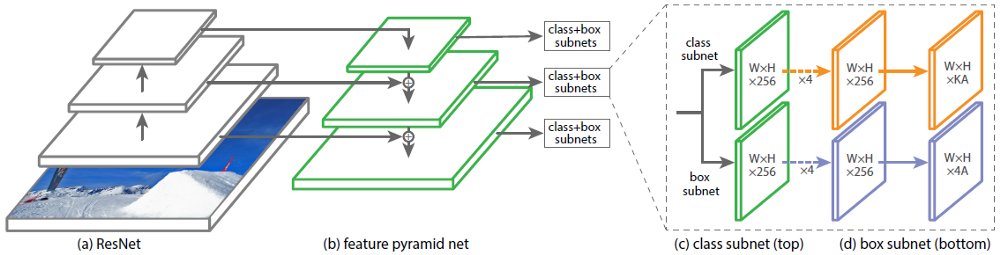

Архитектурно RetinaNet состоит из 4 нейронных сетей.

Backbone состоит из двух связанных нейронных сетей ResNet (а) – основной сети, служащей для извлечения признаков из поступающего на вход изображения и Feature Pyramid Net (FPN) (b) использующейся поверх ResNet.

Далее на уровнях от P3 до P7 выделяются по 9 областей определения объектов (анкеров) площадью от 32х32 до 512х512 пикселей с соотношением сторон 1:2, 1:1 и 2:1 один на уровень. У каждой такой области определен один вектор классификации длиной по количеству классов и 4 координатный вектор рамки по углам этой области. Эти области назначаются объектам с использованием порогового значения IoU 0,5 и фону, если IoU находится в пределах от 0 до 0,4.

Классификационная подсеть (c) – это подсеть, предсказывающая вероятность присутствия объекта в каждой пространственной позиции.	Подсеть представляет собой FCN, в которой примененено четыре сверточных слоя 3×3 с 256 фильтрами, за каждым из которых следует слой активации ReLU, за которым следует сверточный слой 3x3 с фильтрами по количеству классов умноженных на количество областей определения объектов (анкеров).

Подсеть регрессии (d) — это подсеть, извлекающая из FPN информацию о координатах рамки области выделений объектов на изображении, решая задачу регрессии.

На выходе сеть декодирует объекты не более чем из 1000 предсказаний с наивысшей оценкой полученной на уровене FPN после достоверности порогового значения 0,05. Далее прогнозы со всех уровней объединяются, и применяется немаксимальное подавление (NMS) с порогом 0,5 для получения окончательных результатов обнаружения объектов.

Таким образом, во время обучения общая потеря фокуса изображения вычисляется как сумма потерь фокуса по всем областям определения объектов с использованием предварительно обученных нейросетей ResNet-50-FPN и ResNet-101-FPN на наборе данных ImageNet.

**Исследование потерь**

Далее в статье обсуждаются результаты исследования потерь нейронной сети обученной на наборе данных COCO. 

Для сбалансированной перекрестной энтропии потерь $α = 0,75$ был получен коэффициент усиления 0,9 AP.

При использовании сбалансированной потери фокуса FL при $γ = 2$ и $α = 0,25$ коэффициент AP в 2,9 показал большее значение по сравнению с потерями сбалансированной перекрестной энтропии CE.

Для объектов переднего плана примерно на $20$% положительных образцов приходится примерно половина положительных потерь. По мере увеличения $γ$ существенно больше фильтруется фоновых объектов.

**Сравнение с другими подходами**

Сети Backbone большего размера обеспечивают более высокую точность, но также и меньшую скорость работы. Время их обучения составляет от 10 до 35 часов, что позволяет RetinaNet превзойти по точности все двухэтапные подходы.

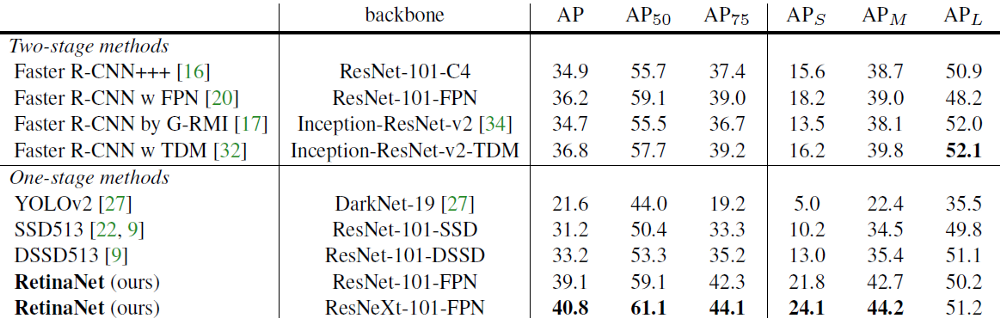
Результаты обнаружения объектов по сравнению с другими сетяби детектирования объектов в тестовой наборе данных COCO

Наибольшую точность нейросеть RetinaNet показала с использованием ResNet-101-FPN. По сравнению с двухэтапными сетями, RetinaNet достигает 2,3 балла по сравнению с самой производительной моделью Faster R-CNN, основанной на Inception-ResNet-v2-TDM.

Вывод: используя потерю фокуса, можно адаптивно сбалансировать общие потери между простыми и жесткими сэмплами.